# Building a drone using RxInfer.jl

In [293]:
using Pkg; Pkg.activate("."); Pkg.instantiate()

  Activating project at `~/MEGA/juliacon/2024/RxInferExperiments/RxInferExperiments`


In [294]:
using RxInfer, LinearAlgebra

## Defining structures

In [295]:
"""
    Environment(; gravitational_constant::Float64 = 9.81)

This structure contains the properties of the environment.
"""
Base.@kwdef struct Environment
    gravitational_constant::Float64 = 9.81
end
get_gravity(env::Environment) = env.gravitational_constant

get_gravity (generic function with 1 method)

In [296]:
"""
    Drone(mass, inertia, radius, force_limit)

This structure contains the properties of the drone.
"""
Base.@kwdef struct Drone
    mass::Float64
    inertia::Float64
    radius::Float64
    force_limit::Float64
end
get_mass(drone::Drone) = drone.mass
get_properties(drone::Drone) = (drone.mass, drone.inertia, drone.radius, drone.force_limit)

get_properties (generic function with 1 method)

In [297]:
"""
    State(x, y, vx, vy, 𝜃, 𝜔)

This structure contains the state of the drone. It contains the position, velocity, and orientation of the drone.
"""
struct State
    x::Float64
    y::Float64
    vx::Float64
    vy::Float64
    𝜃::Float64
    𝜔::Float64
end
get_state(state::State) = (state.x, state.y, state.vx, state.vy, state.𝜃, state.𝜔)

get_state (generic function with 1 method)

## Model specification

In [298]:
"""
    state_transition(state, actions, drone, environment, dt)

This function computes the next state of the drone given the current state, the actions, the drone properties and the environment properties.
"""
function state_transition(state, actions, drone::Drone, environment::Environment, dt)

    # extract drone properties
    m, I, r, limit = get_properties(drone)

    # extract environment properties
    g = get_gravity(environment)

    # extract feasible actions
    Fl, Fr   = clamp.(actions, 0, limit)
        
    # extract state properties
    x, y, vx, vy, θ, ω = state

    # compute forces and torques
    Fg = m * g
    Fy = (Fl + Fr) * cos(θ) - Fg
    Fx = (Fl + Fr) * sin(θ)
    𝜏  = (Fl - Fr) * r

    # compute movements
    ax = Fx / m
    ay = Fy / m
    vx_new = vx + ax * dt
#     vy_new = vx + ay * dt # old version
    vy_new = vy + ay * dt   # new version
    x_new  = x + vx * dt + ax * dt^2 / 2
    y_new  = y + vy * dt + ay * dt^2 / 2
        
    # compute rotations
    α = 𝜏 / I
    ω_new = ω + α * dt
    θ_new = θ + ω * dt + α * dt^2 / 2
	
    return [x_new, y_new, vx_new, vy_new, θ_new, ω_new]

end

state_transition

In [299]:
@model function drone_model(drone, environment, initial_state, goal, horizon, dt)	

	# extract environment properties
	g = get_gravity(environment)

	# extract drone properties
	m = get_mass(drone)

	# initial state prior
	s[1] ~ MvNormal(mean = initial_state, covariance = 1e-5 * I)

	for i in 1:horizon

		# prior on actions (mean compensates for gravity)
		u[i] ~ MvNormal(μ = [m * g / 2, m * g / 2], Σ = diageye(2))

		# state transition
		s[i + 1] ~ MvNormal(
            μ = state_transition(s[i], u[i], drone, environment, dt), 
			Σ = 1e-10 * I
		)
	end
	
	s[end] ~ MvNormal(mean = goal, covariance = 1e-5 * diageye(6))

end

## Probabilistic inference

In [300]:
@meta function drone_meta()

	# approximate the state transition function using the Unscented transform
	state_transition() -> Unscented()

end

drone_meta (generic function with 1 method)

In [301]:
function move_to_target(drone::Drone, env::Environment, start::State, target, horizon, dt)

    results = infer(
        model = drone_model(
            drone = drone, 
            environment = env,
            horizon = horizon,
            dt = dt
        ),
        data  = (
            initial_state = collect(get_state(start)), 
            goal = [target[1], target[2], 0, 0, 0, 0],
        ),
        meta  = drone_meta(),
        returnvars = (s = KeepLast(), u = KeepLast())
    )

    return results

end

move_to_target (generic function with 1 method)

In [302]:
drone = Drone(
    mass = 1,
    inertia = 1,
    radius = 0.2,
    force_limit = 30.0
)

env = Environment()

start = State(0.0, 0.0, 0.0, 0.0, 0.0, 0.0)

target = [-0.8, 0.6]

horizon = 40

dt = 0.05

results = move_to_target(drone, env, start, target, horizon, dt)

Inference results:
  Posteriors       | available for (s, u)


## Plotting

In [303]:
using Plots

In [304]:
function plot_drone!(p, drone::Drone, state::State; color = :black)
    x, y, x_a, y_a, θ, ω = get_state(state)
    _, _, radius, _ = get_properties(drone)
    dx = radius * cos(θ)
    dy = radius * sin(θ)

    drone_position = [ x ], [ y ]
    drone_engines  = [ x - dx, x + dx ], [ y + dy, y - dy ]
    drone_coordinates = [ x - dx, x, x + dx ], [ y + dy, y, y - dy ]

    rotation_matrix = [ cos(-θ) -sin(-θ); sin(-θ) cos(-θ) ]
    engine_shape = [ -1 0 1; 1 -1 1 ]
    drone_shape  = [ -2 -2 2 2 ; -1 1 1 -1 ]
    
    engine_shape = rotation_matrix * engine_shape
    drone_shape  = rotation_matrix * drone_shape
    engine_marker = Shape(engine_shape[1, :], engine_shape[2, :])
    drone_marker  = Shape(drone_shape[1, :], drone_shape[2, :])
    
    scatter!(p, drone_position[1], drone_position[2]; color = color, label = false, marker = drone_marker)
    scatter!(p, drone_engines[1], drone_engines[2]; color = color, label = false, marker = engine_marker, ms = 10)
    plot!(p, drone_coordinates; color = color, label = false)

    return p
end

plot_drone! (generic function with 1 method)

In [305]:
function animate_drone(drone::Drone, target, results::InferenceResult)

    states = hcat(map(p -> mean(p), results.posteriors[:s])...)
    
    animate_drone(drone, target, states)

end
function animate_drone(drone::Drone, target, states)
        @gif for k in 1:size(states,2)

        # plot target
        p = scatter([target[1]], [target[2]], label = "target"; color = :red)

        # plot drone
        plot_drone!(p, drone, State(states[:, k]...))

        xlims!(-1.5, 1.5)
        ylims!(-1.5, 1.5)
    
    end
end

animate_drone (generic function with 2 methods)

[ Info: Saved animation to /home/andreas/MEGA/juliacon/2024/RxInferExperiments/RxInferExperiments/tmp.gif


Plots.AnimatedGif("/home/andreas/MEGA/juliacon/2024/RxInferExperiments/RxInferExperiments/tmp.gif")
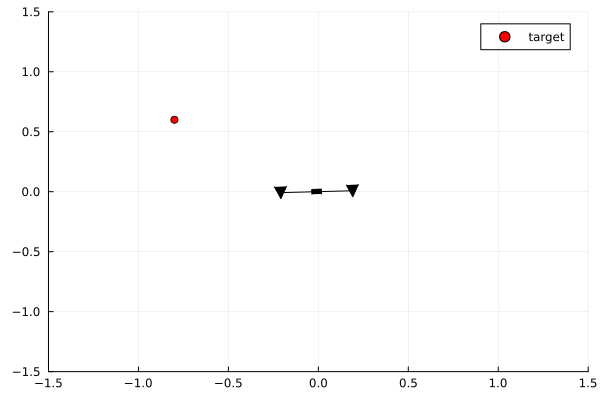

In [306]:
animate_drone(drone, target, results)

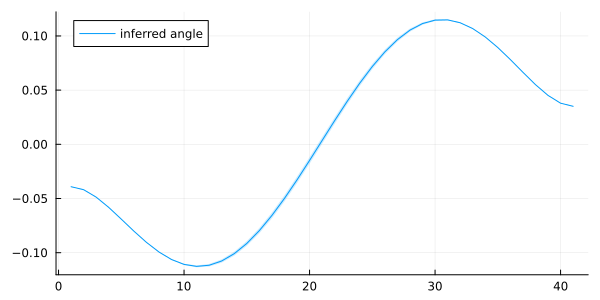

In [307]:
let 
    inferred_angle_mean = map(p -> mean(p)[5], results.posteriors[:s])
    inferred_angle_std  = map(p -> std(p)[5],  results.posteriors[:s])
    plot(inferred_angle_mean; ribbon = inferred_angle_std, fillalpha = 0.2, label = "inferred angle", size=(600,300))
end

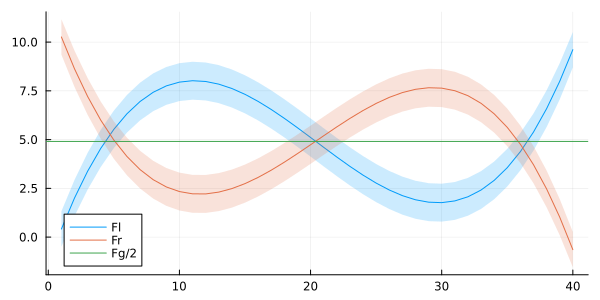

In [308]:
let 
    inferred_forces_mean = hcat(map(p -> mean(p), results.posteriors[:u])...)'
    inferred_forces_std  = hcat(map(p -> sqrt.(var(p)),  results.posteriors[:u])...)'
    plot(inferred_forces_mean[:,1]; ribbon = inferred_forces_std[:,1], fillalpha = 0.2, label = "Fl", size=(600,300))
    plot!(inferred_forces_mean[:,2]; ribbon = inferred_forces_std[:,2], fillalpha = 0.2, label = "Fr", size=(600,300))
    
    hline!([get_mass(drone) * get_gravity(env) / 2], label = "Fg/2")
end

## Does the plan match reality?

The above simulation is all happening in the probabilistic model. 
Due to approximations in RxInfer and the nature of probabilistic inference, 
this may not match reality. To check if it does, we simulate reality with
the inferred controls.

In [309]:
function animate_real_drone(drone::Drone, target, results::InferenceResult)

    actions = mean.(results.posteriors[:u])

    states = [collect(get_state(start))]
    for a in actions
        push!(states, state_transition(states[end], a, drone, env, dt))
    end

    animate_drone(drone, target, hcat(states...))

end

animate_real_drone (generic function with 1 method)

[ Info: Saved animation to /home/andreas/MEGA/juliacon/2024/RxInferExperiments/RxInferExperiments/tmp.gif


Plots.AnimatedGif("/home/andreas/MEGA/juliacon/2024/RxInferExperiments/RxInferExperiments/tmp.gif")
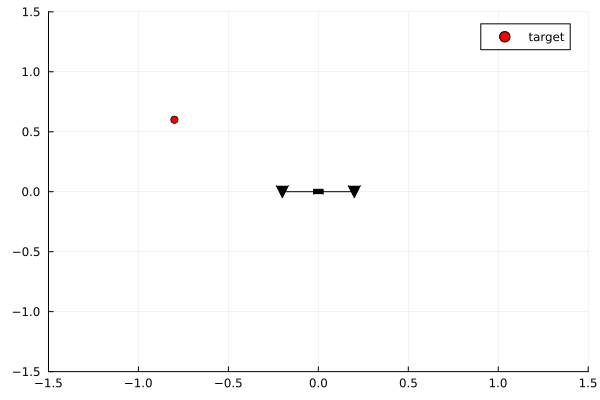

In [310]:
animate_real_drone(drone, target, results)

As can be seen, the inferred plan does not achieve the goal. To fix this, we can incorporate feedback from the real world at each step of the simulation.

## Incorporate real-world feedback

In [311]:
function move_to_target_with_feedback(drone::Drone, env::Environment, start::State, target, horizon, dt)
	states = empty([collect(get_state(start))])
	controls = empty([[1.0, 1.0]])
	cur_state = collect(get_state(start))
	
	for t in 1:horizon
    	results = infer(
        	model = drone_model(
            	drone = drone, 
            	environment = env,
            	horizon = horizon + 1 - t,
            	dt = dt
        	),
        	data  = (
        	    initial_state = collect(cur_state), 
        	    goal = [target[1], target[2], 0, 0, 0, 0],
        	),
        	meta  = drone_meta(),
        	returnvars = (s = KeepLast(), u = KeepLast())
    	)
		control = mean.(results.posteriors[:u])[1]
		cur_state = state_transition(cur_state, control, drone, env, dt)
		push!(controls, control)
		push!(states, cur_state)
	end
	return (controls, states)
end

move_to_target_with_feedback (generic function with 1 method)

In [312]:
controls, states = move_to_target_with_feedback(drone, env, start, target, horizon, dt);

[ Info: Saved animation to /home/andreas/MEGA/juliacon/2024/RxInferExperiments/RxInferExperiments/tmp.gif


Plots.AnimatedGif("/home/andreas/MEGA/juliacon/2024/RxInferExperiments/RxInferExperiments/tmp.gif")
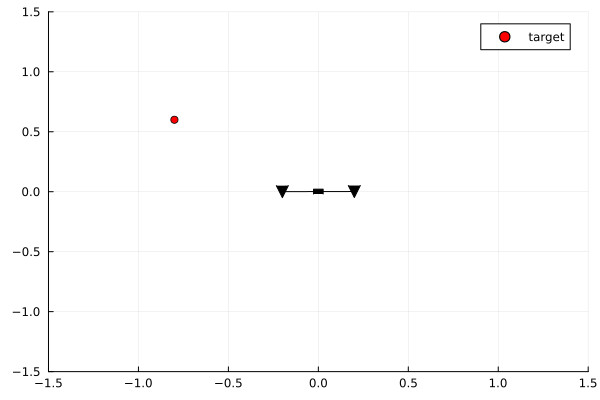

In [313]:
animate_drone(drone, target, hcat(states...))

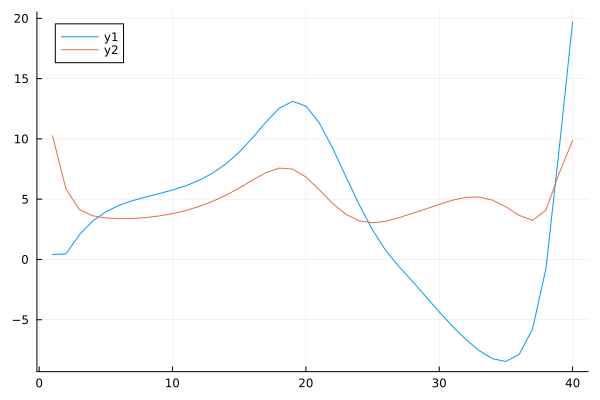

In [314]:
plot((c -> c[1]).(controls))
plot!((c -> c[2]).(controls))